In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, ZeroPadding2D, Cropping2D
from tensorflow.keras.models import Model
from shutil import copyfile, rmtree
from timeit import default_timer as timer

In [2]:
# Вспомогательная функция для доступа к файлам относительно корня директория с данными.
INPUT_ROOT = "../input/gtsrb-german-traffic-sign"
def from_input(path):
    return os.path.join(INPUT_ROOT, path)

In [3]:
# Загружаем таблицу с данными о данных.
train_info = pd.read_csv(from_input("Train.csv"))
train_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
# Посмотрим как выглядят наши данные.
train_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [5]:
# сколько примеров в каждом из классов
train_info.groupby('ClassId')['ClassId'].count()

ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: ClassId, dtype: int64

In [6]:
test_info =  pd.read_csv(from_input("Test.csv"))
test_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
test_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [8]:
# сколько примеров в каждом из классов
test_info.groupby('ClassId')['ClassId'].count()

ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: ClassId, dtype: int64

In [9]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Показываем изображения в сетке 6х8.
nrows = 8
ncols = 6

pic_offset = 0 # Чтобы итерировать по изображениям каждый раз когда запустим код ниже.

In [10]:
def show_images(offset):
    fig = plt.gcf()
    fig.set_size_inches(ncols*3, nrows*3)

    for i in range(43):
        # subplot индексы начинаются с 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        subdir = os.path.join(from_input('train'), str(i))
        files = os.listdir(subdir)
        img_path = os.path.join(subdir, files[offset % len(files)])
        img = mpimg.imread(img_path)
        #print(img.shape)
        plt.imshow(img)

    plt.show()

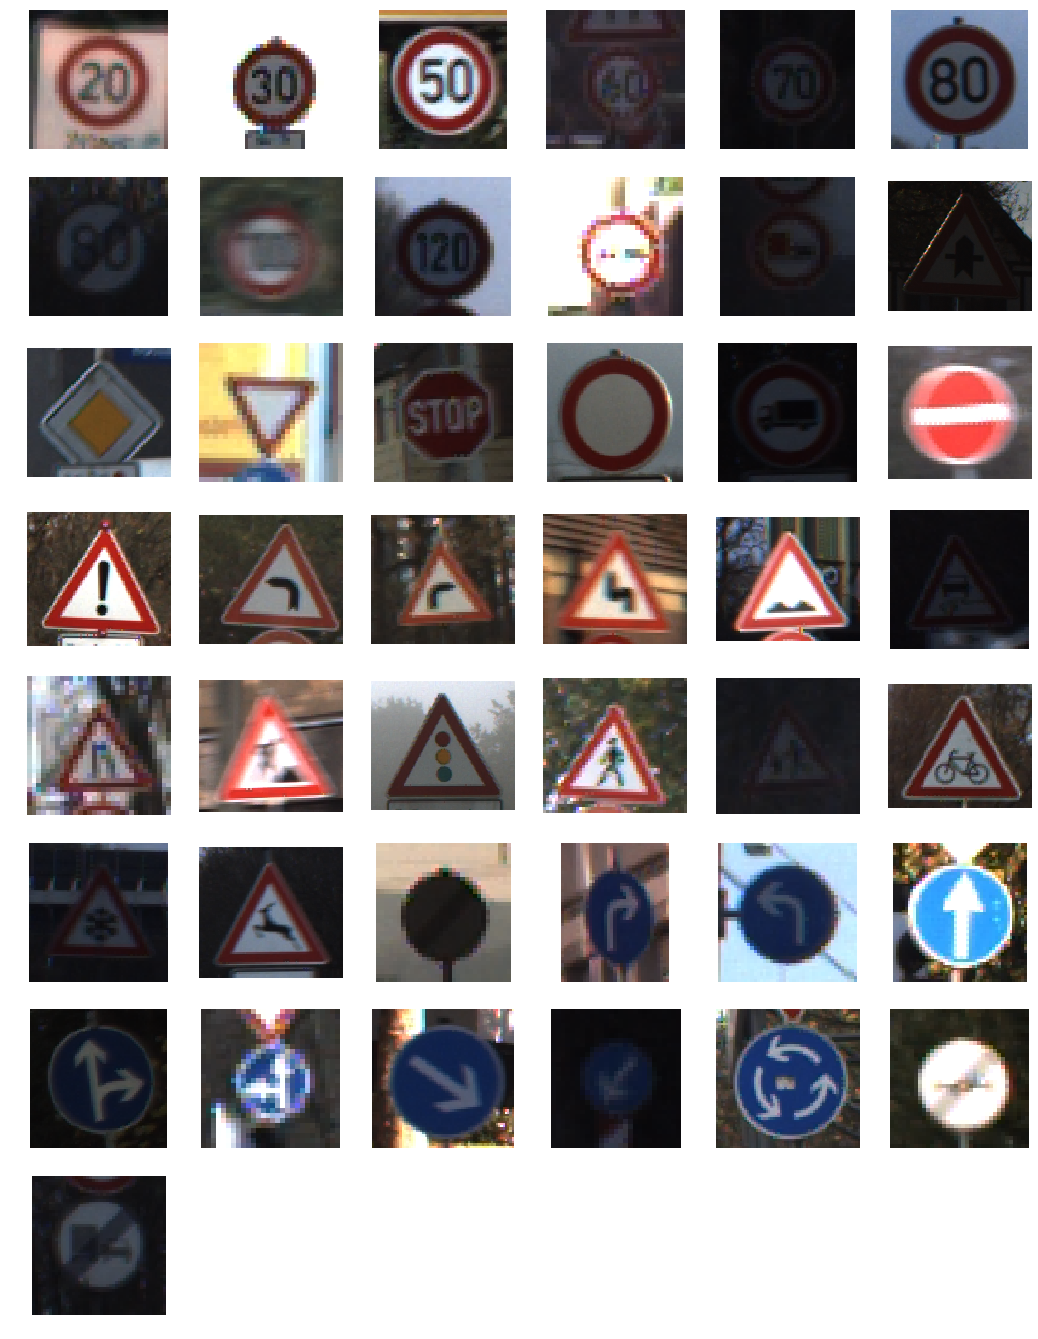

In [11]:
show_images(pic_offset)
pic_offset += 1

Загрузка и подготовка данных:

In [12]:
TARGET_SIZE = (40, 40) # изображения будут изменены до этого размера
FLATTEN_SIZE = TARGET_SIZE[0] * TARGET_SIZE[1] * 3
BATCH_SIZE=300

In [13]:
paths = train_info['Path'].values
y_train = train_info['ClassId'].values

indices = np.arange(y_train.shape[0])
randgen = random.Random(62)
randgen.shuffle(indices)

paths = paths[indices]
y_train = y_train[indices]
y_train = to_categorical(y_train, 43)

train_data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = load_img(os.path.join(from_input('train'), f.replace('Train/', '')), target_size=TARGET_SIZE)
    train_data.append(img_to_array(image))

print('Data loaded.              ')


Data loaded.              


In [14]:
X_train = tf.keras.applications.vgg16.preprocess_input(np.array(train_data))
train_data = None

In [15]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(X_train,
                                    y_train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)

train_aug_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       rotation_range = 18,
                                       width_shift_range = 0.18,
                                       height_shift_range = 0.18,
                                       shear_range = 0.18,
                                       zoom_range = 0.18,
                                       horizontal_flip = False)

train_aug_generator = train_datagen.flow(X_train,
                                    y_train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)

In [16]:
paths = test_info['Path'].values
y_test = test_info['ClassId'].values
y_test = to_categorical(y_test, 43)

test_data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = load_img(os.path.join(from_input('test'), f.replace('Test/', '')), target_size=TARGET_SIZE)
    test_data.append(img_to_array(image))

print('Data loaded.              ')

Data loaded.              


In [17]:
X_test = tf.keras.applications.vgg16.preprocess_input(np.array(test_data))
test_data = None

In [18]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow(X_test,
                                    y_test,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    seed=17)

Некоторые вспомогательные функции:

In [19]:
def plot(history, plot_acc = True):
    %matplotlib inline

    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    
    loss=history.history['loss']
    epochs=range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.xlabel('Epoch')
    plt.title('Training loss')
    # validation
    plt.plot(epochs, history.history['val_loss'], 'b', "Validation Loss")

    if plot_acc:
        acc=history.history['acc']
        plt.figure()
        plt.plot(epochs, acc, 'r', "Training Accuracy")
        plt.title('Training accuracy')
        plt.xlabel('Epoch')
        plt.plot(epochs, history.history['val_acc'], 'b', "Validation Accuracy")



In [20]:
def show_layers(model):
    print('Name\tOutput shape\tActivation\tInitializer')
    for l in model.layers:
        print('{0}({1})\t{2}\t{3}\t{4}'
            .format(l.name,
              l.__class__.__name__,
              l.output_shape,
              l.activation.__name__ if hasattr(l, 'activation') else '<none>',
              l.kernel_initializer.__class__.__name__ if hasattr(l, 'kernel_initializer') else '<none>'))


def custom_summary(model):
    model.summary()
    show_layers(model)

In [21]:
VERBOSE=1

In [22]:
def train_model(model, optimizer, epochs, train_generator):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = timer()
    history = model.fit_generator(train_generator,
                        epochs=epochs,
                        verbose=VERBOSE,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.0001, patience=2)],
                        validation_data=test_generator,
                        steps_per_epoch= round(X_train.shape[0] / BATCH_SIZE))
    end_time = timer()
    
    print('==============================')
    print('Optimizer: ', optimizer.__class__.__name__)
    print('Learning rate: ', optimizer.get_config()['learning_rate'])
    print('Epochs: ', epochs)
    print('==============================')
    print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))
    
    acc=history.history['acc'][-1]
    test_acc = model.evaluate_generator(test_generator)[1]
    
    print('Results at the end of training: acc={1:.02f}%, test_acc={2:.02f}%'
          .format(i, acc*100, test_acc*100))

    plot(history)

In [23]:
def get_classificator_model(base_model, last_output):
    x = Flatten()(last_output)
    x = Dropout(0.33)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.33)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(43, activation='softmax')(x)           

    model = Model(base_model.input, x)
    return model

Запускаем готовую сеть на наших данных.

**Эксперимент №1**: Реализуем переноса признакового описания.

In [24]:
IMG_SHAPE = TARGET_SIZE + (3,)
pretrained_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

pretrained_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 40, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 40, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 20, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 20, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 20, 20, 128)       147584    
______________________________________________________________

В этом эксперименте не хотим тренировать слои уже обученной сети.

In [25]:
for layer in pretrained_model.layers:
    layer.trainable = False

Не будем использовать последний блок VGG16, так как он наверное слишком приспособлен для задаче на которой тренировался. Начальные слои обычно представляют более общие признаки.

Тренируем только нашу часть сети. Первую часть VGG16 используем как метод выделения признаков.

last layer output shape:  (None, 5, 5, 512)
Epoch 1/50
131/131 [==============================] - 11s 85ms/step - loss: 2.6239 - acc: 0.3220 - val_loss: 1.6466 - val_acc: 0.5302
Epoch 2/50
131/131 [==============================] - 6s 49ms/step - loss: 1.4791 - acc: 0.5579 - val_loss: 1.2271 - val_acc: 0.6302
Epoch 3/50
131/131 [==============================] - 6s 49ms/step - loss: 1.0484 - acc: 0.6704 - val_loss: 1.0398 - val_acc: 0.6749
Epoch 4/50
131/131 [==============================] - 6s 49ms/step - loss: 0.8025 - acc: 0.7392 - val_loss: 0.9905 - val_acc: 0.7006
Epoch 5/50
131/131 [==============================] - 6s 49ms/step - loss: 0.6637 - acc: 0.7828 - val_loss: 0.9177 - val_acc: 0.7219
Epoch 6/50
131/131 [==============================] - 6s 49ms/step - loss: 0.5659 - acc: 0.8117 - val_loss: 0.8909 - val_acc: 0.7331
Epoch 7/50
131/131 [==============================] - 6s 49ms/step - loss: 0.4830 - acc: 0.8399 - val_loss: 0.8661 - val_acc: 0.7407
Epoch 8/50
131/131 [====

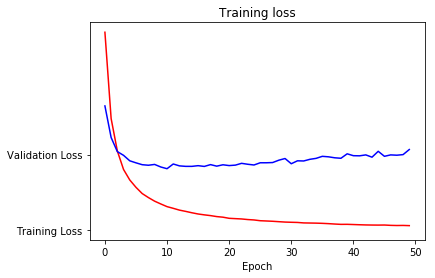

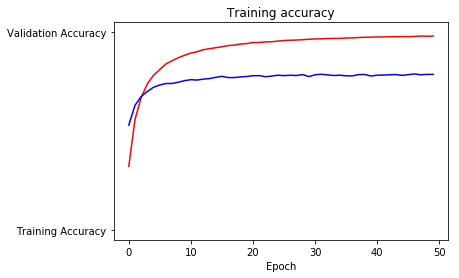

In [26]:
last_layer = pretrained_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

optimizer=Adam(learning_rate=0.0001)
epochs=50
train_model(get_classificator_model(pretrained_model, last_output), optimizer, epochs, train_generator)

Получаем сильное переобучение. На тренировочной выборке модель сходится слишком быстро.

**Эксперимент №2**: Попробуем полностью обучать сеть начиная с уже готовых весов начальных слоёв.

In [27]:
pretrained_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = True

last layer output shape:  (None, 5, 5, 512)
Epoch 1/50
131/131 [==============================] - 17s 129ms/step - loss: 3.3622 - acc: 0.1810 - val_loss: 2.2355 - val_acc: 0.4204
Epoch 2/50
131/131 [==============================] - 14s 108ms/step - loss: 1.9944 - acc: 0.4566 - val_loss: 1.3415 - val_acc: 0.6234
Epoch 3/50
131/131 [==============================] - 14s 108ms/step - loss: 1.2229 - acc: 0.6488 - val_loss: 0.8370 - val_acc: 0.7639
Epoch 4/50
131/131 [==============================] - 14s 108ms/step - loss: 0.7498 - acc: 0.7748 - val_loss: 0.5621 - val_acc: 0.8352
Epoch 5/50
131/131 [==============================] - 14s 108ms/step - loss: 0.4635 - acc: 0.8599 - val_loss: 0.4645 - val_acc: 0.8625
Epoch 6/50
131/131 [==============================] - 14s 107ms/step - loss: 0.3190 - acc: 0.9025 - val_loss: 0.3619 - val_acc: 0.8914
Epoch 7/50
131/131 [==============================] - 14s 108ms/step - loss: 0.2368 - acc: 0.9276 - val_loss: 0.3348 - val_acc: 0.8973
Epoch 8/50


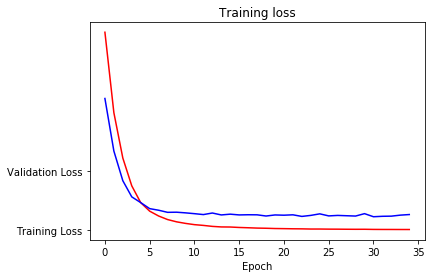

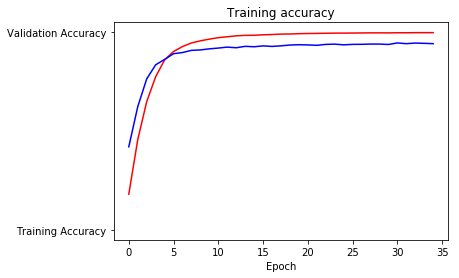

In [28]:
last_layer = pretrained_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

optimizer=Adam(learning_rate=0.00001)
epochs=50
train_model(get_classificator_model(pretrained_model, last_output), optimizer, epochs, train_generator)

**Эксперимент №3**: Попробуем полностью обучать сеть начиная случайной подборки весов всей сети.

In [29]:
deep_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)
for layer in deep_model.layers:
    layer.trainable = True

last layer output shape:  (None, 5, 5, 512)
Epoch 1/50
131/131 [==============================] - 16s 123ms/step - loss: 3.5412 - acc: 0.0627 - val_loss: 3.4148 - val_acc: 0.0817
Epoch 2/50
131/131 [==============================] - 14s 108ms/step - loss: 3.1665 - acc: 0.1438 - val_loss: 2.4590 - val_acc: 0.2931
Epoch 3/50
131/131 [==============================] - 14s 108ms/step - loss: 2.1266 - acc: 0.3776 - val_loss: 1.7028 - val_acc: 0.4729
Epoch 4/50
131/131 [==============================] - 14s 108ms/step - loss: 1.4967 - acc: 0.5262 - val_loss: 1.2316 - val_acc: 0.6122
Epoch 5/50
131/131 [==============================] - 14s 108ms/step - loss: 1.0658 - acc: 0.6548 - val_loss: 0.8848 - val_acc: 0.7152
Epoch 6/50
131/131 [==============================] - 14s 108ms/step - loss: 0.7729 - acc: 0.7492 - val_loss: 0.7180 - val_acc: 0.7700
Epoch 7/50
131/131 [==============================] - 14s 109ms/step - loss: 0.5743 - acc: 0.8131 - val_loss: 0.6478 - val_acc: 0.7979
Epoch 8/50


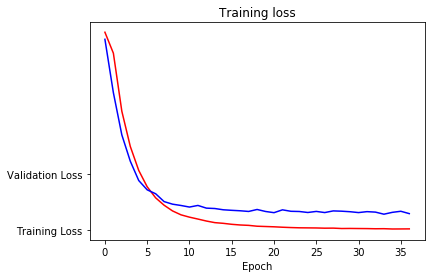

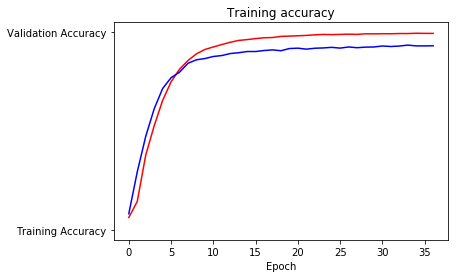

In [30]:
last_layer = deep_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

optimizer=Adam(learning_rate=0.00005)
epochs=50
train_model(get_classificator_model(deep_model, last_output), optimizer, epochs, train_generator)

Для сравнения, с такими данными запустим самую хорошую модель из педыдущей лабы

Epoch 1/50
131/131 [==============================] - 15s 112ms/step - loss: 3.5217 - acc: 0.0992 - val_loss: 3.3388 - val_acc: 0.1634
Epoch 2/50
131/131 [==============================] - 12s 91ms/step - loss: 3.1223 - acc: 0.2239 - val_loss: 2.9240 - val_acc: 0.2468
Epoch 3/50
131/131 [==============================] - 12s 90ms/step - loss: 2.6195 - acc: 0.3336 - val_loss: 2.4529 - val_acc: 0.3641
Epoch 4/50
131/131 [==============================] - 12s 91ms/step - loss: 2.1391 - acc: 0.4445 - val_loss: 2.0638 - val_acc: 0.4557
Epoch 5/50
131/131 [==============================] - 12s 90ms/step - loss: 1.7542 - acc: 0.5434 - val_loss: 1.7586 - val_acc: 0.5376
Epoch 6/50
131/131 [==============================] - 12s 90ms/step - loss: 1.4501 - acc: 0.6272 - val_loss: 1.5139 - val_acc: 0.5986
Epoch 7/50
131/131 [==============================] - 12s 91ms/step - loss: 1.2145 - acc: 0.6953 - val_loss: 1.3293 - val_acc: 0.6363
Epoch 8/50
131/131 [==============================] - 12s 91m

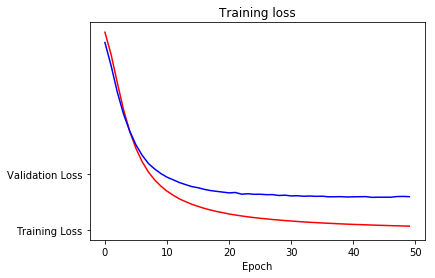

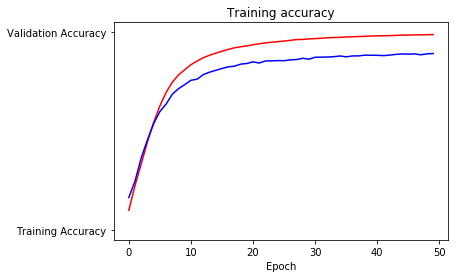

In [31]:
optimizer=Adam(learning_rate=0.00001)
epochs=50

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, optimizer, epochs, train_generator)

Попробуем ещё улучшить собственную сеть.

Epoch 1/50
131/131 [==============================] - 15s 112ms/step - loss: 3.4879 - acc: 0.0807 - val_loss: 3.4420 - val_acc: 0.1337
Epoch 2/50
131/131 [==============================] - 13s 99ms/step - loss: 3.2481 - acc: 0.1579 - val_loss: 3.1577 - val_acc: 0.2076
Epoch 3/50
131/131 [==============================] - 13s 99ms/step - loss: 2.8557 - acc: 0.2489 - val_loss: 2.7186 - val_acc: 0.2846
Epoch 4/50
131/131 [==============================] - 13s 99ms/step - loss: 2.4941 - acc: 0.3178 - val_loss: 2.3935 - val_acc: 0.3568
Epoch 5/50
131/131 [==============================] - 13s 98ms/step - loss: 2.2002 - acc: 0.3913 - val_loss: 2.1043 - val_acc: 0.4344
Epoch 6/50
131/131 [==============================] - 13s 99ms/step - loss: 1.9188 - acc: 0.4597 - val_loss: 1.8306 - val_acc: 0.4945
Epoch 7/50
131/131 [==============================] - 13s 98ms/step - loss: 1.6645 - acc: 0.5278 - val_loss: 1.5811 - val_acc: 0.5726
Epoch 8/50
131/131 [==============================] - 13s 99m

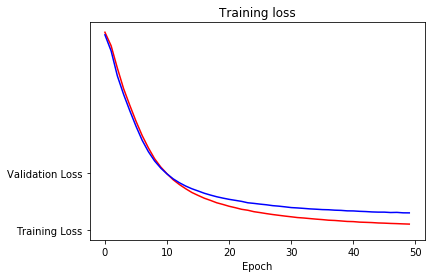

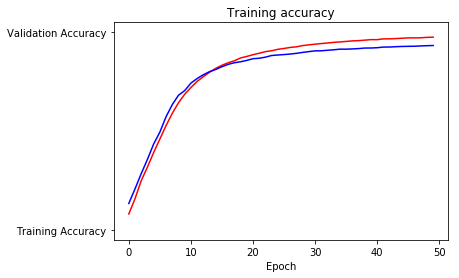

In [32]:
optimizer=Adam(learning_rate=0.00001)
epochs=50

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1024, activation='tanh'),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, optimizer, epochs, train_generator)

Epoch 1/50
131/131 [==============================] - 15s 112ms/step - loss: 3.4846 - acc: 0.0824 - val_loss: 3.4448 - val_acc: 0.1333
Epoch 2/50
131/131 [==============================] - 13s 99ms/step - loss: 3.2366 - acc: 0.1608 - val_loss: 3.1316 - val_acc: 0.2184
Epoch 3/50
131/131 [==============================] - 13s 100ms/step - loss: 2.8413 - acc: 0.2481 - val_loss: 2.7172 - val_acc: 0.2651
Epoch 4/50
131/131 [==============================] - 13s 99ms/step - loss: 2.5136 - acc: 0.3094 - val_loss: 2.4137 - val_acc: 0.3501
Epoch 5/50
131/131 [==============================] - 13s 99ms/step - loss: 2.2412 - acc: 0.3750 - val_loss: 2.1483 - val_acc: 0.4155
Epoch 6/50
131/131 [==============================] - 13s 99ms/step - loss: 1.9806 - acc: 0.4420 - val_loss: 1.9011 - val_acc: 0.4837
Epoch 7/50
131/131 [==============================] - 13s 99ms/step - loss: 1.7331 - acc: 0.5060 - val_loss: 1.6660 - val_acc: 0.5428
Epoch 8/50
131/131 [==============================] - 13s 98

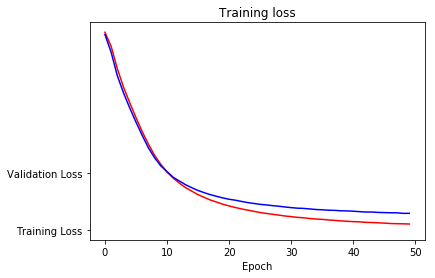

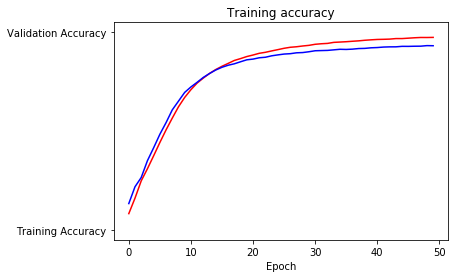

In [33]:
optimizer=Adam(learning_rate=0.00001)
epochs=50

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(1024, activation='tanh'),
    tf.keras.layers.Dropout(0.33),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, optimizer, epochs, train_aug_generator)